In [1]:
import numpy as np
import pandas as pd
import xarray as xr
import rioxarray as rxa
from shapely import geometry
import matplotlib.pyplot as plt

import sys
sys.path.append('..')

from phase_o_matic.download import download_era
from phase_o_matic.preprocess import get_vapor_partial_pressure, convert_pressure_to_pascals, interpolate_to_heights
from phase_o_matic.phase_delay import calculate_refractive_indexes, integrate_refractivity

from era import initconst

In [17]:
# import numpy as np
# levels = ['1','2','3','5','7','10','20','30','50', '70','100','125',\
#     '150','175','200','225', '250','300','350','400','450','500','550','600','650',\
#     '700','750','775','800','825', '850','875','900','925','950','975','1000']
# levels = np.array(levels).astype('int32')
# lats = np.linspace(43, 45, 9).astype('float32')
# lons = np.linspace(-116, -115, 10).astype('float32')
# ds = xr.Dataset(
#     {
#         'z': (['longitude', 'latitude','level','time'], np.random.random((10, 9, 37, 1)).astype('float32'), {'units':'m**2 s**-2', 'long_name':'Geopotential', 'standard_name' :'geopotential'}),
#         't': (['longitude', 'latitude','level','time'], np.random.random((10, 9, 37, 1)).astype('float32'), {'units' :'K', 'long_name' :'Temperature', 'standard_name' :'air_temperature'}),
#         'q': (['longitude', 'latitude','level','time'], np.random.random((10, 9, 37, 1)).astype('float32'), {'units' :'kg kg**-1', 'long_name' :'Specific humidity', 'standard_name' :'specific_humidity'}),
#         'vpr': (['longitude', 'latitude','level','time'], np.random.random((10, 9, 37, 1)).astype('float32')),
#     },  
#     coords = {
#         "longitude" : (["longitude"], lons, {'units' :'degrees_east', 'long_name' :'longitude'}),
#         "latitude" : (["latitude"], lats, {'units' :'degrees_north', 'long_name' :'latitude'}),
#         "level" : (["level"], levels, {'units' :'millibars', 'long_name' :'pressure_level'}),
#         "time" : (["time"], [pd.to_datetime('2020-01-04T09:00')], {'long_name' :'time'}),
#     },
#     attrs={'Conventions' :'CF-1.6', 'history' :'2023-05-04 17:03:14 GMT by grib_'}
# )

In [12]:
# for i in np.arange(200, 300):
test = era.isel(time = 0, latitude = 0, longitude = 1, level = 32)
test['t'] = 30+273
test['r'] = 75
print(test['t'].data.ravel()[0] - 273)
print(test['level'].data.ravel()[0]/100)
print(test['r'].data.ravel()[0]/100)
svp = cc_era(test['t'])
print(svp.data.ravel()[0])
get_vapor_partial_pressure(test)['vpr'].data.ravel()[0]
# plt.scatter(i-273, svp/10000, color = 'blue', marker = 'x')
# plt.yscale('log')
# plt.show()

30
900.0
0.75
5623.5760522609835


4217.682039195737

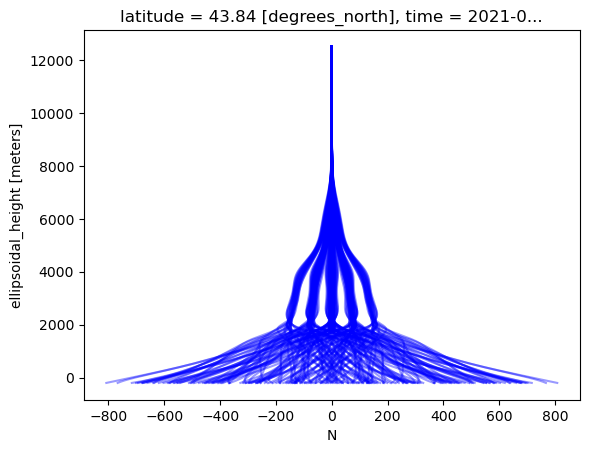

In [9]:
from itertools import product
fig, ax = plt.subplots()
for i, j in product(range(3), range(5)):
    for k, l in product(range(3), range(5)):
        if i == k and j == l:
            continue
        (ds['N'].isel(time = 0, latitude = k, longitude = l) - ds['N'].isel(time = 0, latitude = i, longitude = j)).plot(y = 'height', color = 'blue', alpha = 0.4)

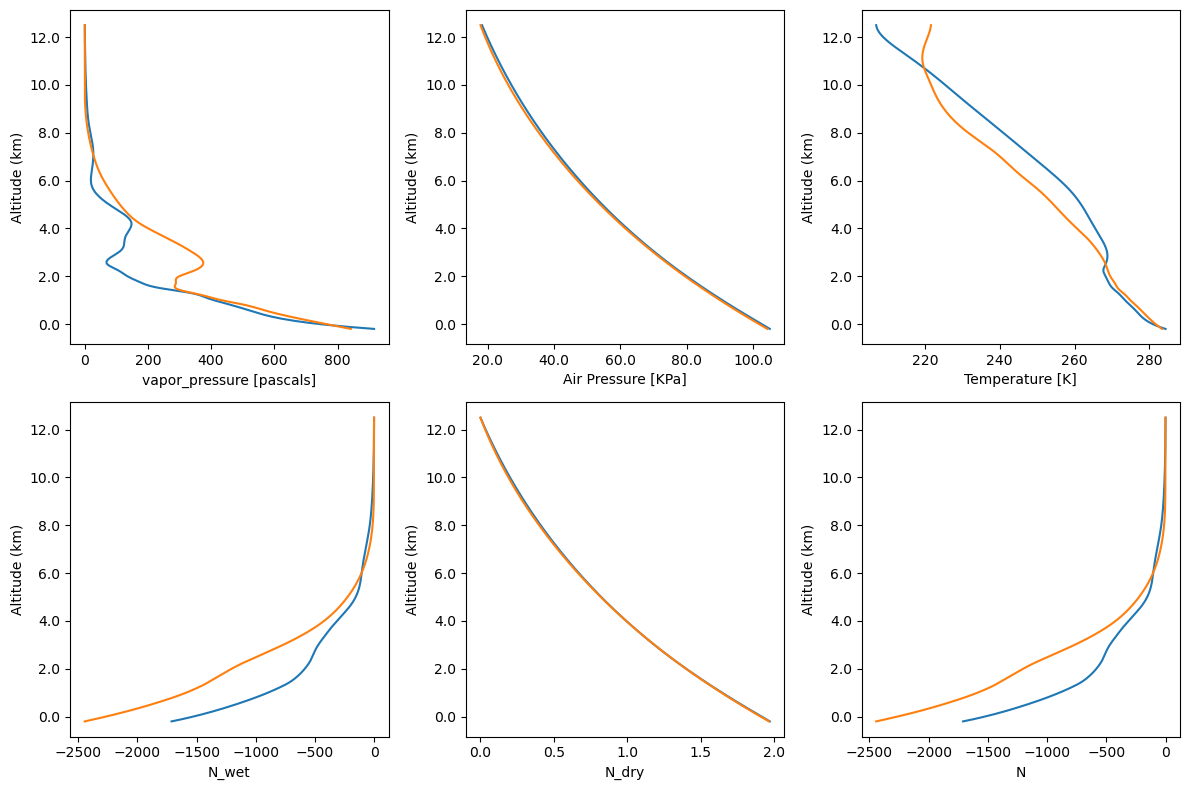

In [10]:
fig, axes = plt.subplots(2, 3, figsize = (12, 8))

ds['vapor_pressure'].isel(time = 0, latitude = 0, longitude = 0).plot(ax = axes[0, 0], y = 'height')
ds['vapor_pressure'].isel(time = 1, latitude = 0, longitude = 0).plot(ax = axes[0, 0], y = 'height')
ds['air_pressure'].isel(time = 0, latitude = 0, longitude = 0).plot(ax = axes[0, 1], y = 'height')
ds['air_pressure'].isel(time = 1, latitude = 0, longitude = 0).plot(ax = axes[0, 1], y = 'height')
ds['temperature'].isel(time = 0, latitude = 0, longitude = 0).plot(ax = axes[0, 2], y = 'height')
ds['temperature'].isel(time = 1, latitude = 0, longitude = 0).plot(ax = axes[0, 2], y = 'height')
ds['N_wet'].isel(time = 0, latitude = 0, longitude = 0).plot(ax = axes[1, 0], y = 'height')
ds['N_wet'].isel(time = 1, latitude = 0, longitude = 0).plot(ax = axes[1, 0], y = 'height')
ds['N_dry'].isel(time = 0, latitude = 0, longitude = 0).plot(ax = axes[1, 1], y = 'height')
ds['N_dry'].isel(time = 1, latitude = 0, longitude = 0).plot(ax = axes[1, 1], y = 'height')
ds['N'].isel(time = 0, latitude = 0, longitude = 0).plot(ax = axes[1, 2], y = 'height')
ds['N'].isel(time = 1, latitude = 0, longitude = 0).plot(ax = axes[1, 2], y = 'height')

def numfmt(x, pos): # your custom formatter function: divide by 100.0
    s = '{}'.format(x / 1000.0)
    return s

import matplotlib.ticker as tkr     # has classes for tick-locating and -formatting
yfmt = tkr.FuncFormatter(numfmt)    # create your custom formatter function

# your existing code can be inserted here
for ax in axes.ravel():
    ax.yaxis.set_major_formatter(yfmt)
    ax.set_ylabel('Altitude (km)')
    ax.set_title('')

axes[0, 1].xaxis.set_major_formatter(yfmt)
axes[0, 1].set_xlabel('Air Pressure [KPa]')
# axes[1,2].set_xscale('log')
plt.tight_layout()

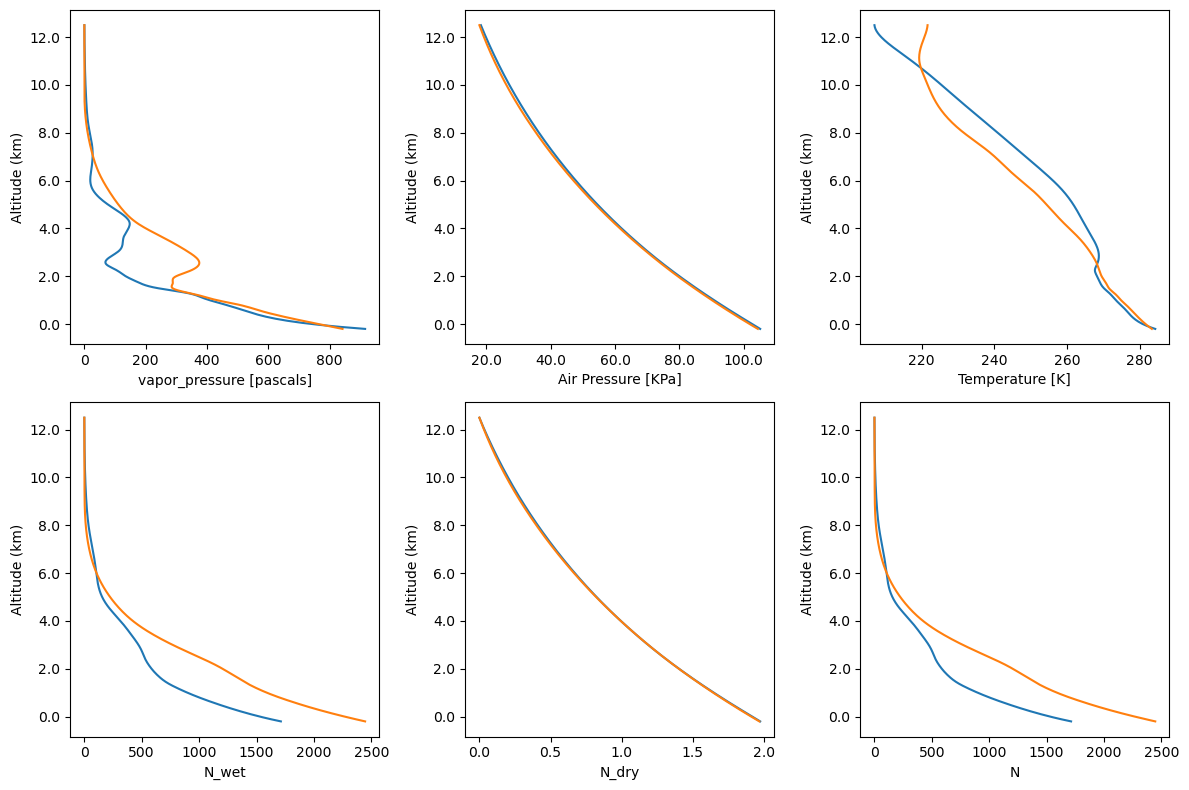

In [134]:
fig, axes = plt.subplots(2, 3, figsize = (12, 8))

ds['vapor_pressure'].isel(time = 0, latitude = 0, longitude = 0).plot(ax = axes[0, 0], y = 'height')
ds['vapor_pressure'].isel(time = 1, latitude = 0, longitude = 0).plot(ax = axes[0, 0], y = 'height')
ds['air_pressure'].isel(time = 0, latitude = 0, longitude = 0).plot(ax = axes[0, 1], y = 'height')
ds['air_pressure'].isel(time = 1, latitude = 0, longitude = 0).plot(ax = axes[0, 1], y = 'height')
ds['temperature'].isel(time = 0, latitude = 0, longitude = 0).plot(ax = axes[0, 2], y = 'height')
ds['temperature'].isel(time = 1, latitude = 0, longitude = 0).plot(ax = axes[0, 2], y = 'height')
ds['N_wet'].isel(time = 0, latitude = 0, longitude = 0).plot(ax = axes[1, 0], y = 'height')
ds['N_wet'].isel(time = 1, latitude = 0, longitude = 0).plot(ax = axes[1, 0], y = 'height')
ds['N_dry'].isel(time = 0, latitude = 0, longitude = 0).plot(ax = axes[1, 1], y = 'height')
ds['N_dry'].isel(time = 1, latitude = 0, longitude = 0).plot(ax = axes[1, 1], y = 'height')
ds['N'].isel(time = 0, latitude = 0, longitude = 0).plot(ax = axes[1, 2], y = 'height')
ds['N'].isel(time = 1, latitude = 0, longitude = 0).plot(ax = axes[1, 2], y = 'height')

def numfmt(x, pos): # your custom formatter function: divide by 100.0
    s = '{}'.format(x / 1000.0)
    return s

import matplotlib.ticker as tkr     # has classes for tick-locating and -formatting
yfmt = tkr.FuncFormatter(numfmt)    # create your custom formatter function

# your existing code can be inserted here
for ax in axes.ravel():
    ax.yaxis.set_major_formatter(yfmt)
    ax.set_ylabel('Altitude (km)')
    ax.set_title('')

axes[0, 1].xaxis.set_major_formatter(yfmt)
axes[0, 1].set_xlabel('Air Pressure [KPa]')
# axes[1,2].set_xscale('log')
plt.tight_layout()

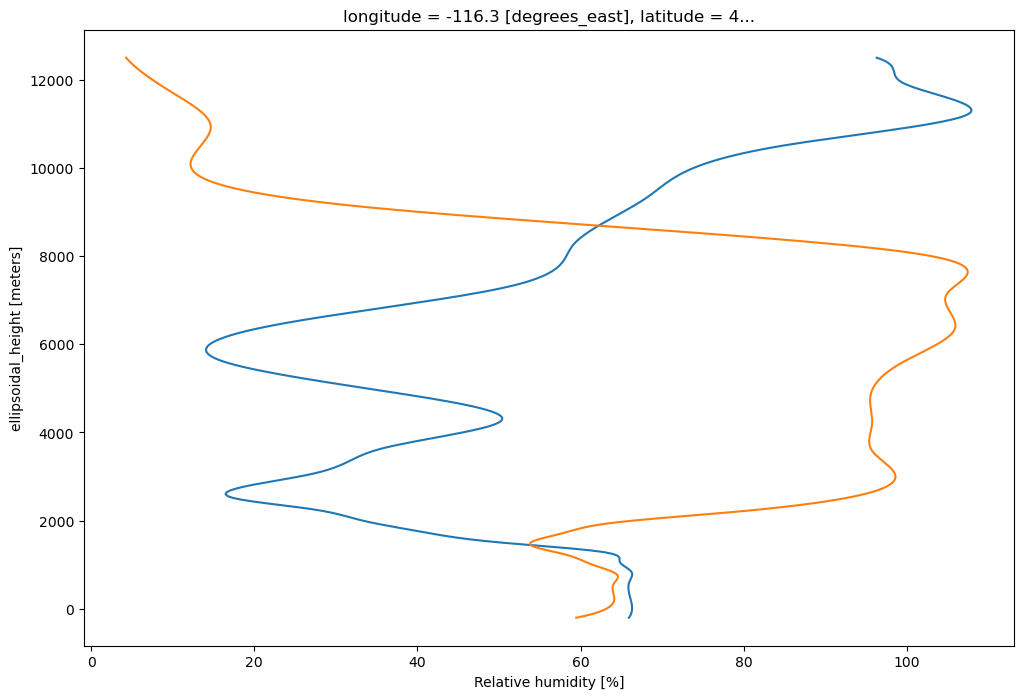

In [135]:
fig, axes = plt.subplots( figsize = (12, 8))

ds['humidity'].isel(time = 0, latitude = 0, longitude = 0).plot(ax = axes, y = 'height')
ds['humidity'].isel(time = 1, latitude = 0, longitude = 0).plot(ax = axes, y = 'height')

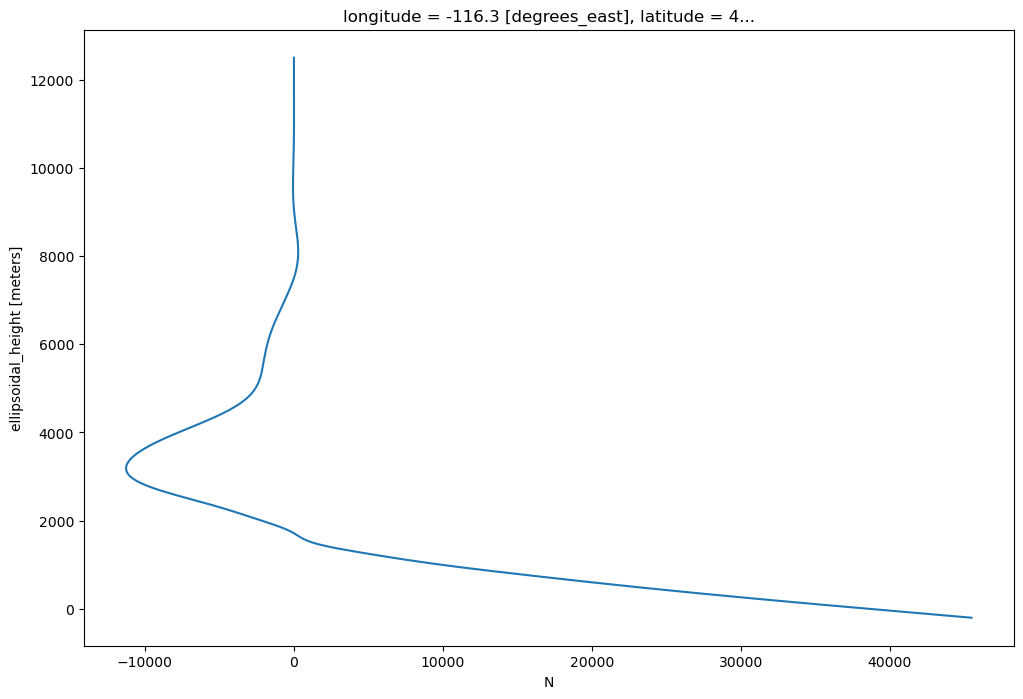

In [128]:
fig, axes = plt.subplots( figsize = (12, 8))

(4*np.pi/0.23*(ds['N'].isel(time = 0, latitude = 0, longitude = 0) - ds['N'].isel(time = 1, latitude = 0, longitude = 0))).plot(ax = axes, y = 'height')


In [14]:
import pyaps3 as pa


In [26]:
import os
filedir = '../data/pyaps'
w, s, e, n = geom.rio.bounds()
pa.ECMWFdload([time1.strftime('%Y%m%d'),time2.strftime('%Y%m%d')], hr='08', filedir=filedir, model='ERA5', snwe=(s,n,w,e))

INFO: You are using the latest ECMWF platform for downloading datasets: https://cds.climate.copernicus.eu/api/v2
{'product_type': 'reanalysis', 'format': 'grib', 'variable': ['geopotential', 'temperature', 'specific_humidity'], 'pressure_level': ['1', '2', '3', '5', '7', '10', '20', '30', '50', '70', '100', '125', '150', '175', '200', '225', '250', '300', '350', '400', '450', '500', '550', '600', '650', '700', '750', '775', '800', '825', '850', '875', '900', '925', '950', '975', '1000'], 'year': '2021', 'month': '01', 'day': '20', 'time': '08:00', 'area': '44.46/-116.31/43.59/-114.90'}


2023-05-05 23:40:43,003 INFO Welcome to the CDS
2023-05-05 23:40:43,005 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2023-05-05 23:40:43,242 INFO Request is queued
2023-05-05 23:40:44,451 INFO Request is running
2023-05-05 23:40:52,313 INFO Request is completed
2023-05-05 23:40:52,314 INFO Downloading https://download-0016.copernicus-climate.eu/cache-compute-0016/cache/data8/adaptor.mars.internal-1683351643.9430902-8753-2-eb1bc944-7718-43bd-8833-4aa718ffe3b0.grib to ../data/pyaps/ERA5_N43.593109687169395_N44.46028463045756_W116.31112480163574_W114.90234565734863_20210120_08.grb (26K)
2023-05-05 23:40:53,813 INFO Download rate 17.4K/s  


{'product_type': 'reanalysis', 'format': 'grib', 'variable': ['geopotential', 'temperature', 'specific_humidity'], 'pressure_level': ['1', '2', '3', '5', '7', '10', '20', '30', '50', '70', '100', '125', '150', '175', '200', '225', '250', '300', '350', '400', '450', '500', '550', '600', '650', '700', '750', '775', '800', '825', '850', '875', '900', '925', '950', '975', '1000'], 'year': '2021', 'month': '01', 'day': '21', 'time': '08:00', 'area': '44.46/-116.31/43.59/-114.90'}


2023-05-05 23:40:54,231 INFO Welcome to the CDS
2023-05-05 23:40:54,232 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2023-05-05 23:40:54,532 INFO Request is queued
2023-05-05 23:40:55,771 INFO Request is running
2023-05-05 23:41:03,570 INFO Request is completed
2023-05-05 23:41:03,571 INFO Downloading https://download-0008-clone.copernicus-climate.eu/cache-compute-0008/cache/data9/adaptor.mars.internal-1683351655.0940769-16672-16-1636c460-bfa1-49db-9e35-ed682be049ef.grib to ../data/pyaps/ERA5_N43.593109687169395_N44.46028463045756_W116.31112480163574_W114.90234565734863_20210121_08.grb (26K)
2023-05-05 23:41:05,837 INFO Download rate 11.5K/s  


['../data/pyaps/ERA5_N43.593109687169395_N44.46028463045756_W116.31112480163574_W114.90234565734863_20210120_08.grb',
 '../data/pyaps/ERA5_N43.593109687169395_N44.46028463045756_W116.31112480163574_W114.90234565734863_20210121_08.grb']

read ISCE geometry files: hgt/los/lat/lon.rdr
calculate tropospheric delay from GRB files...
------------------------------------------------
INFO: INCIDENCE ANGLE AS AN ARRAY
INFO: AREA COVERAGE IN SNWE: (33.85, 30.05, 129.05, 132.45)
PROGRESS: READING GRIB FILE
INFO: USING PRESSURE LEVELS OF ERA-INT OR ERA-5 DATA
INFO: IMAGE DIMENSIONS: 15 LATITUDES AND 13 LONGITUDES
PROGRESS: INTERPOLATING FROM PRESSURE TO HEIGHT LEVELS
PROGRESS: COMPUTING DELAY FUNCTIONS
INFO: INCIDENCE ANGLE AS AN ARRAY
INFO: AREA COVERAGE IN SNWE: (33.85, 30.05, 129.05, 132.45)
PROGRESS: READING GRIB FILE
INFO: USING PRESSURE LEVELS OF ERA-INT OR ERA-5 DATA
INFO: IMAGE DIMENSIONS: 15 LATITUDES AND 13 LONGITUDES
PROGRESS: INTERPOLATING FROM PRESSURE TO HEIGHT LEVELS
PROGRESS: COMPUTING DELAY FUNCTIONS
PROGRESS: FINE INTERPOLATION OF HEIGHT LEVELS
PROGRESS: CREATE THE BILINEAR INTERPOLATION FUNCTION
PROGRESS: MAPPING THE DELAY
[============================================================]      0s /      0s 
PROGRES

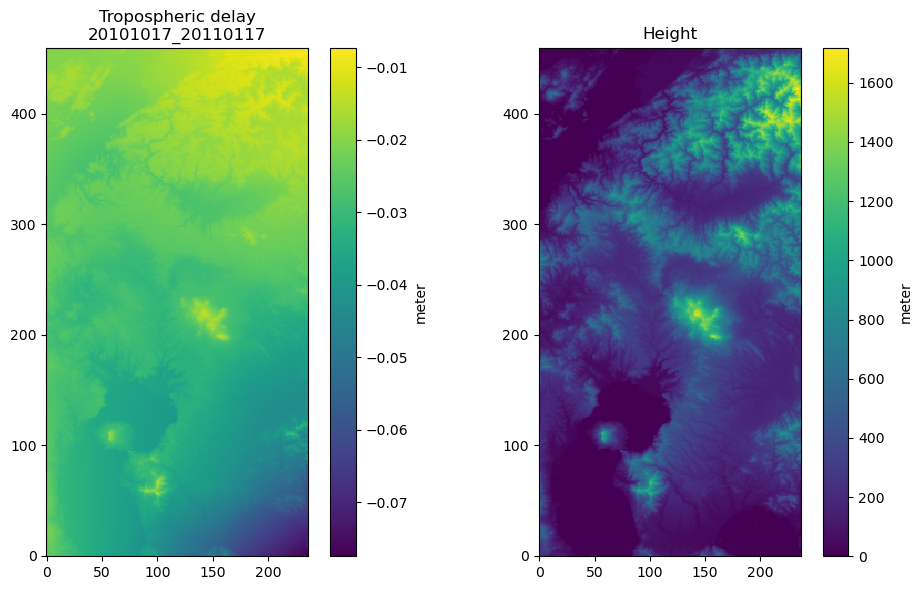

In [31]:
data_dir = '/Users/zachkeskinen/Documents/phase-o-matic/PyAPS/tests/data'
# read geometry files
print('read ISCE geometry files: hgt/los/lat/lon.rdr')
dem = pa.utils.read_data(os.path.join(data_dir, 'hgt.rdr'))
inc = pa.utils.read_data(os.path.join(data_dir, 'los.rdr'), dname='inc')
lat = pa.utils.read_data(os.path.join(data_dir, 'lat.rdr'))
lon = pa.utils.read_data(os.path.join(data_dir, 'lon.rdr'))

# calculate
print('calculate tropospheric delay from GRB files...')
print('------------------------------------------------')
grb_file1 = os.path.join(data_dir, 'ERA5/ERA5_N30_N40_E120_E140_20101017_14.grb')
grb_file2 = os.path.join(data_dir, 'ERA5/ERA5_N30_N40_E120_E140_20110117_14.grb')
obj1 = pa.PyAPS(grb_file1, dem=dem, inc=inc, lat=lat, lon=lon, grib='ERA5', verb=True)
obj2 = pa.PyAPS(grb_file2, dem=dem, inc=inc, lat=lat, lon=lon, grib='ERA5', verb=True)
phs = obj2.getdelay() - obj1.getdelay()

# plot
date12 = '{}_{}'.format(grb_file1.split('_')[-2], grb_file2.split('_')[-2])
titles = [f'Tropospheric delay\n{date12}', 'Height']
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=[10, 6])
for ax, data, title in zip(axs, [phs, dem], titles):
    im = ax.imshow(data, interpolation='nearest')
    # axis format
    ax.invert_yaxis()
    ax.set_title(title)
    cbar = fig.colorbar(im, ax=ax)
    cbar.set_label('meter')
fig.tight_layout()

print('------------------------------------------------')
print('Passed tropospheric delay calculation from ERA5.')
print('------------------------------------------------')
plt.show()